# multiple comparisons correction comparison

a confusing title: there is different ways in which to make multiple comparisons, namely  looking at the chance number
of significant time bins for individual context_pair probe combinations, or pooling across context_pairs, probes, or both

these alternatives are implemented in src.metrics.significance._significance where the parameter
multiple_comparisons_axis can be None (for no correction, the old way) or a list of ints specifiying the dimensions
of the array over which pool and count multiple comparisons.

on the pipeline these  different sets of dimensions are coded as keywords:
multiple_corrections = {'none':None,
                        'full': [1,2,3],
                        'time': [3],
                        'probe': [2,3],
                        'context_pair': [1,3]}



Furthermore, there is the question on howe to deals with significance for the mean values, There is two appraoches so far
* Take the mean of the significance and if > 0 then the mean value is significant (old) key: "mean"
* set the non significant values to 0 and calculate the mean (new) key: "zeros"
* Do something with the p values (mean?) and use to calculate new significance (not implemented)

In [91]:
from configparser import ConfigParser
from pathlib import Path
from joblib import load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from src.visualization.fancy_plots import unit_line
import seaborn as sns
import itertools as itt


In [92]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [93]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [94]:
# imports dataframe and add relevant new fields
DF = load(Path('../data/consolidated_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
DF['id'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id_probe', 'probe']].agg('_'.join, axis=1)

In [95]:
# for the the mean signficance (old) compares the difference between pairs of multiple comparisons
print(DF.columns)
good_cols = ['mult_comp_corr', 'stim_type', 'analysis', 'region', 'id_probe',
             'id', 'context_pair', 'probe', 'metric', 'value']

ff_mean_signif = DF.mean_signif_type == 'mean'
ff_probe = DF.probe == 'mean'
ff_contex = DF.context_pair == 'mean'


filtered = DF.loc[ff_mean_signif & ff_probe & ff_contex, good_cols]
print(any(filtered.duplicated()))
_ = good_cols.pop(-1)
_ = good_cols.pop(0)
pivoted = pd.pivot_table(data=filtered, values='value', index=good_cols, columns='mult_comp_corr', aggfunc='first')

# print(pivoted.head(10))

Index(['cellid', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
       'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region', 'id',
       'id_probe'],
      dtype='object')
False


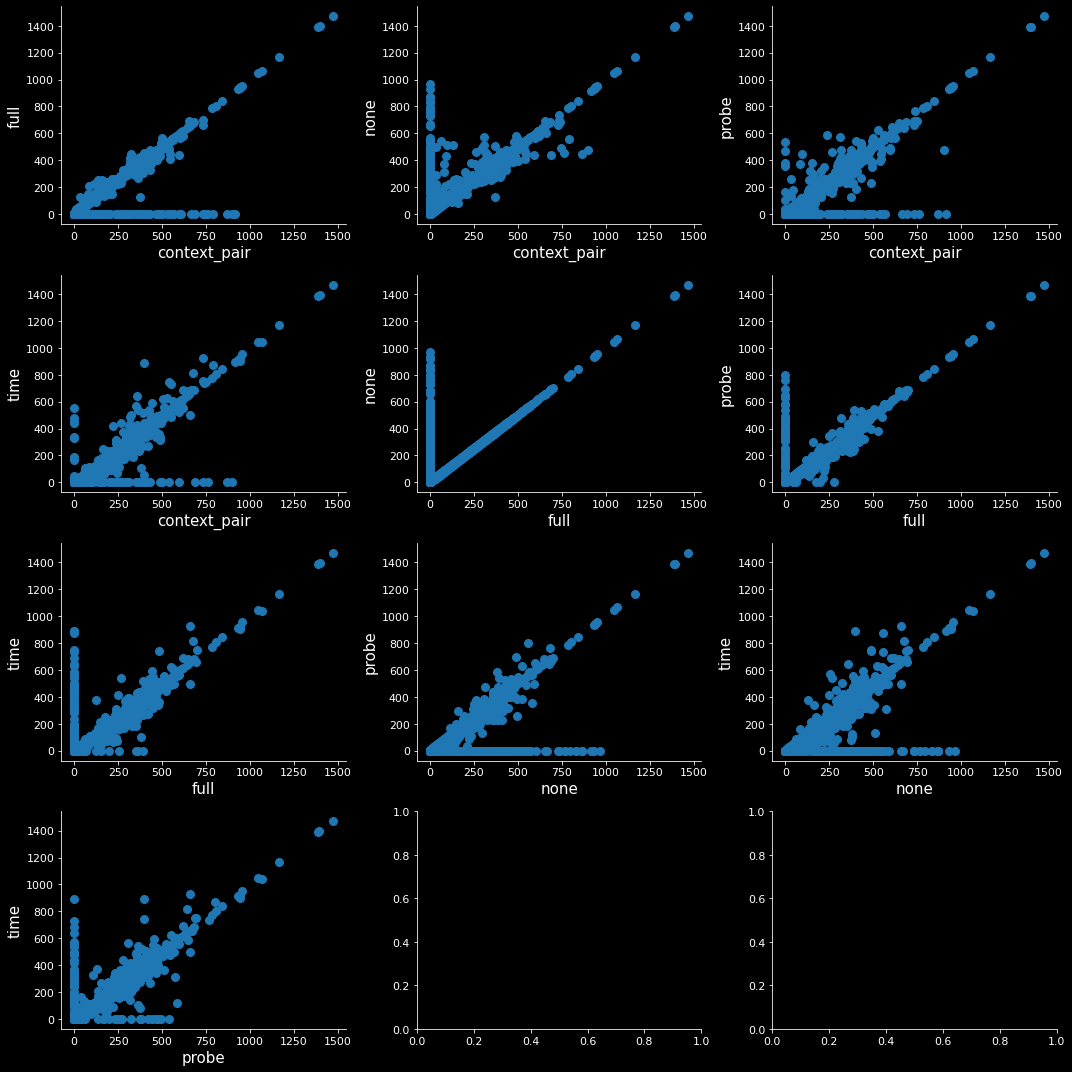

In [96]:
fig, axes = plt.subplots(4, 3, figsize=(15,15))
axes = np.ravel(axes)
for ii, (X, Y) in enumerate(itt.combinations(pivoted.columns, 2)):
    ax = axes[ii]

    ax.scatter(pivoted[X], pivoted[Y])
    ax.set_xlabel(X)
    ax.set_ylabel(Y)

this plot is lame. besides the dispersion in the unit line, the more astringent multiple comparisons lead to a bunch of
zero values

Better to plot the parameter spaces across different combinations of multiple_comparisons, mean significance treatment and
analysis type.

The following plot uses only mean values, and pools both triplets and permutations.

duplicates?:  False


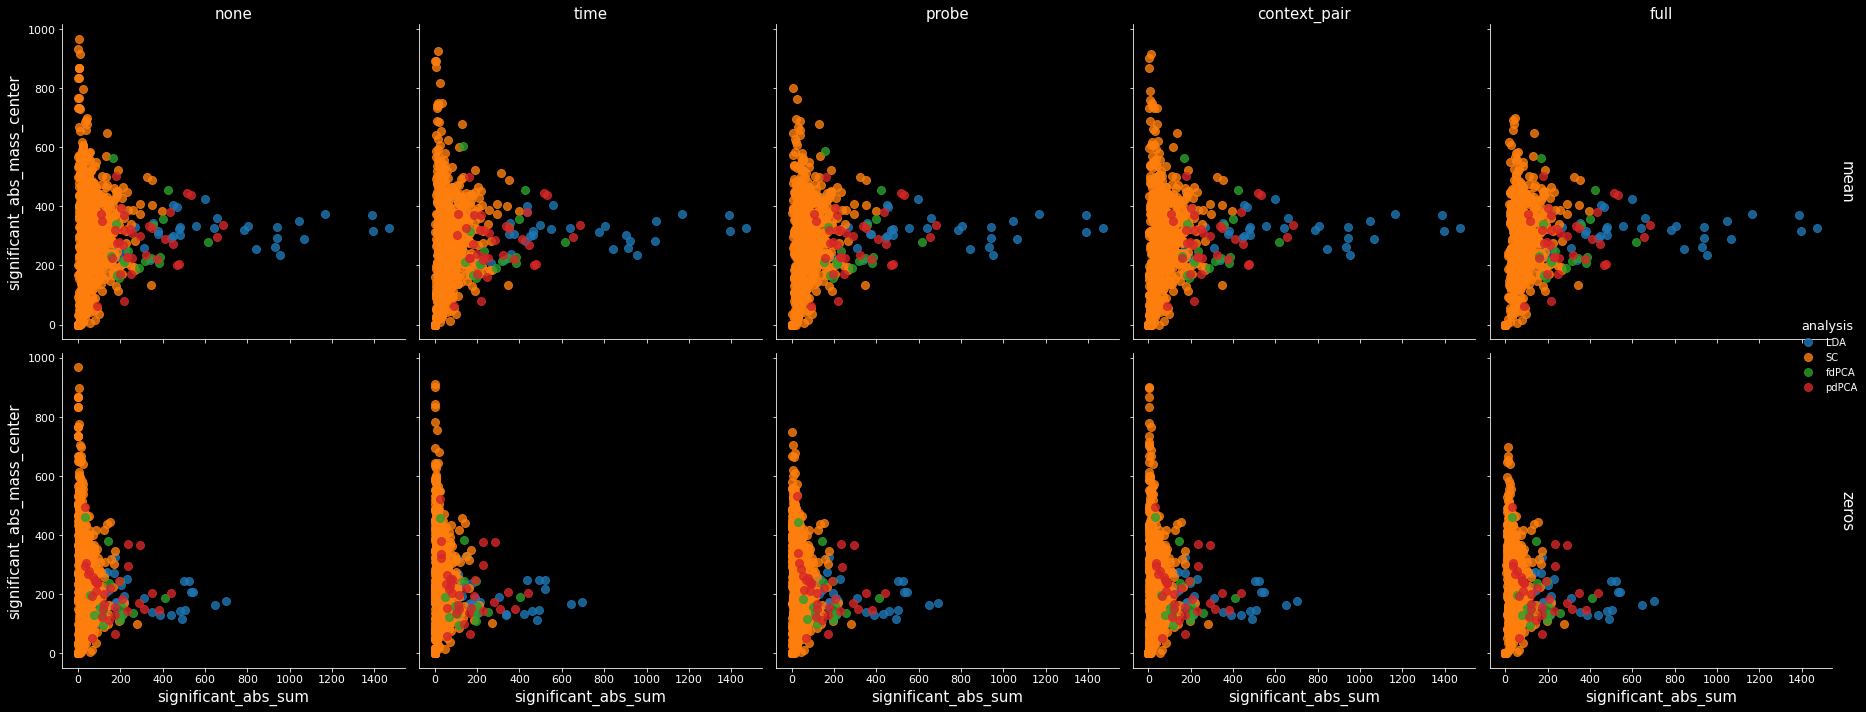

In [97]:
good_cols = ['mean_signif_type', 'mult_comp_corr', 'stim_type', 'analysis', 'region', 'id_probe',
             'id', 'context_pair', 'probe', 'metric', 'value']
ff_probe = DF.probe == 'mean'
ff_contex = DF.context_pair == 'mean'

filtered = DF.loc[ff_probe & ff_contex, good_cols]

print('duplicates?: ',any(filtered.duplicated()))

_ = good_cols.pop(-1) #pops value
_ = good_cols.pop(-1) #pops metric

pivoted = filtered.pivot_table(values='value', index=good_cols, columns='metric', aggfunc='first').reset_index()
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center', data=pivoted,
               hue='analysis', col='mult_comp_corr', row='mean_signif_type',fit_reg=False,
               col_order=['none', 'time', 'probe', 'context_pair', 'full'],
               row_order=['mean', 'zeros'])

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


Lets focus on the single cell case, since its the most numerous and noisy

False
Index(['mean_signif_type', 'mult_comp_corr', 'stim_type', 'region', 'id_probe',
       'id', 'context_pair', 'probe', 'significant_abs_mass_center',
       'significant_abs_sum'],
      dtype='object', name='metric')


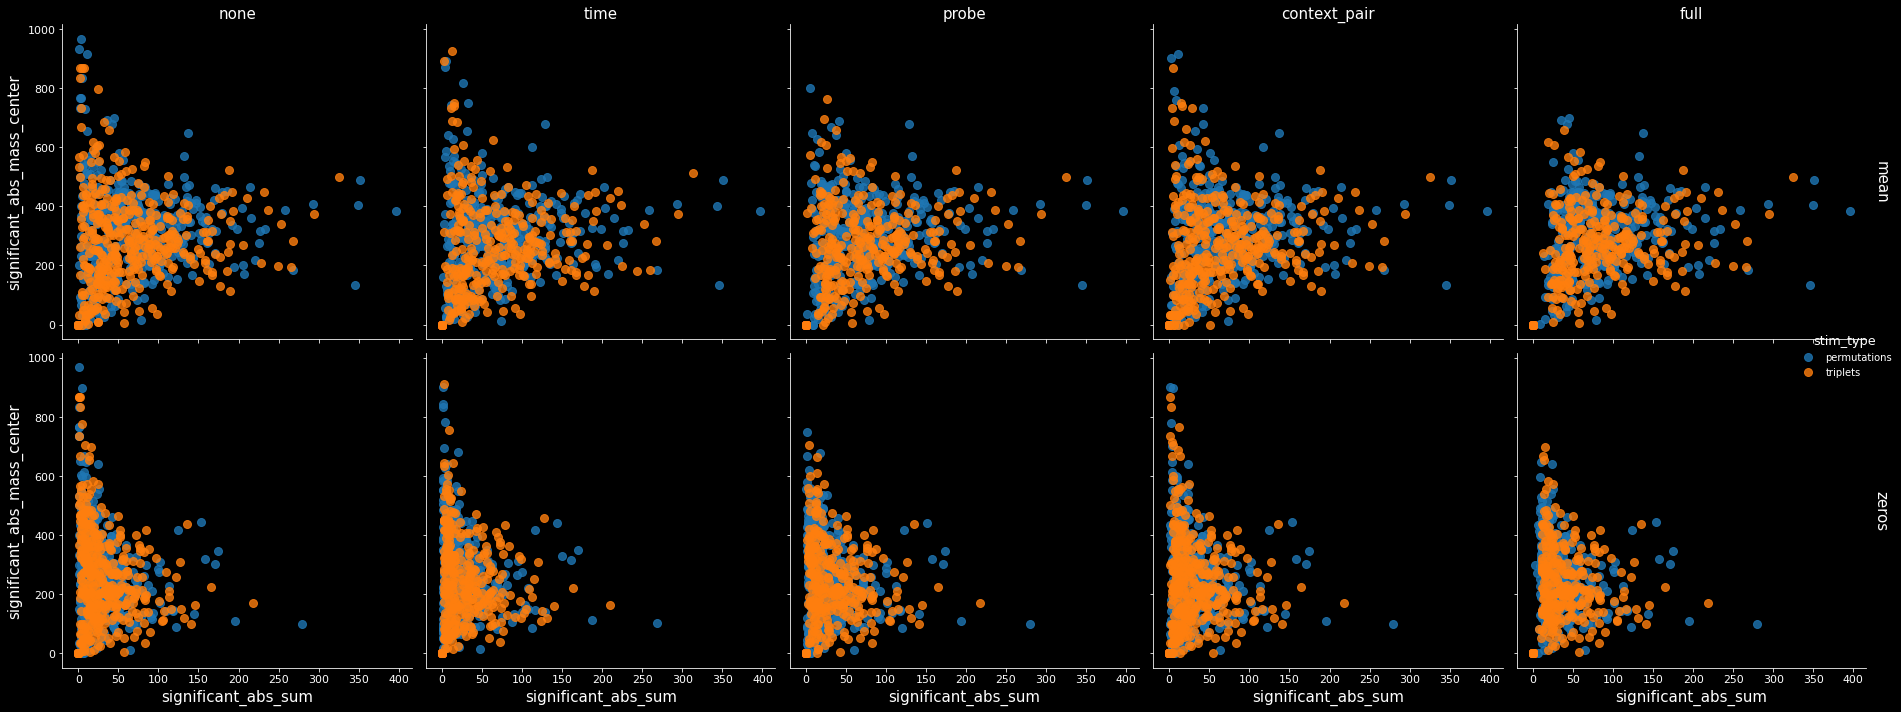

In [98]:
good_cols = ['mean_signif_type', 'mult_comp_corr', 'stim_type', 'region', 'id_probe',
             'id', 'context_pair', 'probe', 'metric', 'value']

ff_probe = DF.probe == 'mean'
ff_contex = DF.context_pair == 'mean'
ff_analysis = DF.analysis == 'SC'

filtered = DF.loc[ff_probe & ff_contex & ff_analysis, good_cols]

print(any(filtered.duplicated()))

_ = good_cols.pop(-1) #pops value
_ = good_cols.pop(-1) #pops metric

pivoted = filtered.pivot_table(values='value', index=good_cols, columns='metric', aggfunc='first').reset_index()
print(pivoted.columns)
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center', data=pivoted,
               hue='stim_type', col='mult_comp_corr', row='mean_signif_type',fit_reg=False,
               col_order=['none', 'time', 'probe', 'context_pair', 'full'],
               row_order=['mean', 'zeros'])

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

It seems that more astringent multiple comparisons corrections (left to right) lead to a decrease in really low amplitude
contextual differences. it is effectively geting rid of random blips of significance. It also shows a meager decreace in
center of mass outliers, however not at the level I would have expected.
Finally the zero way of dealing with mean significance is strongly reducing the integral values, which I hipothesised were
being overestimated.

undoubtedly keeping the full multiple comparison correction is the right idea. The zero mean gives a lower bound mean
dprime, which is good. lets see closer how the different mean significance affect the metrics

False
Index(['stim_type', 'analysis', 'region', 'id_probe', 'id', 'context_pair',
       'probe', 'metric', 'mean', 'zeros'],
      dtype='object', name='mean_signif_type')


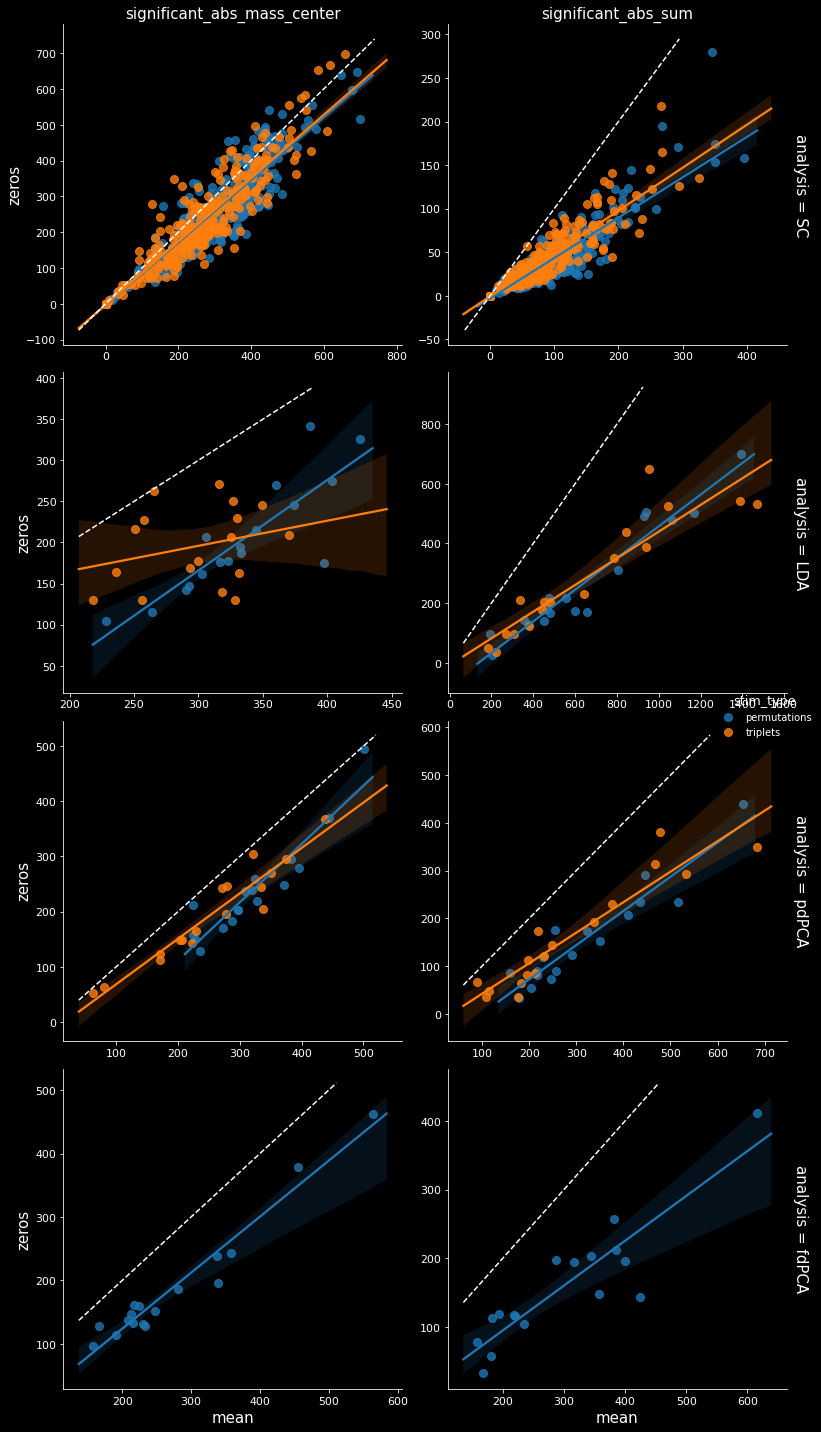

In [99]:
good_cols = ['mean_signif_type', 'stim_type', 'analysis', 'region', 'id_probe',
             'id', 'context_pair', 'probe', 'metric', 'value']

ff_probe = DF.probe == 'mean'
ff_contex = DF.context_pair == 'mean'
ff_mult_comp = DF.mult_comp_corr == 'full'

filtered = DF.loc[ff_probe & ff_contex & ff_mult_comp, good_cols]

print(any(filtered.duplicated()))

_ = good_cols.pop(0)
_ = good_cols.pop(-1)

pivoted = filtered.pivot_table(values='value', index=good_cols, columns='mean_signif_type', aggfunc='first').reset_index()
print(pivoted.columns)
g = sns.lmplot(x='mean', y='zeros', data=pivoted,
               hue='stim_type', col='metric', row='analysis', sharex=False, sharey=False,
               row_order=['SC', 'LDA', 'pdPCA', 'fdPCA'], fit_reg=True)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(col_template="{col_name}")

axes = g.axes
axes = np.ravel(axes)
for ax in axes:
    _ = unit_line(ax, square_shape=False, color='white')

again, the integral seems to be most affected, whereas the center of mass follows the unit line pretty closely.
this gives me the confidense to keep using the zero approach